# Gold price prediction using LSTM with the help of volatility quality and HMA indicators

## Load required libraries

In [1]:
%reset -f
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
import math

## Indicators constants

In [2]:
VQPeriod=5
HPeriod=25
inpFilter=1.0/100
expSmoothing=2
LSTM_look_back = 25

## Function for data rearrangement

In [3]:
def create_dataset(dataset, look_back=1):
    if (dataset.ndim==1):
        dataset=dataset.to_frame()
    dataX, dataY = [], []    
    for i in range(dataset.shape[0]-look_back):
        a = (dataset.iloc[i:(i+look_back), :]).values.tolist()
        dataX.append(a)
        dataY.append(float(dataset.iloc[i + look_back, 0]))
    return np.array(dataX).astype(float), np.array(dataY)

## Load data (from Dukascopy)

In [4]:
df = pd.read_csv('XAUUSD.csv')
df2=(df['Local time']).str.split(pat=' ', n=1, expand=True)
df['Date']=pd.to_datetime(df2[0], format='%d.%m.%Y')
df.drop('Local time', axis=1, inplace=True)
df.set_index('Date', inplace=True)
df['Volume'] = df['Volume'].astype('int')
df['Gain']=(df['Close'].diff()).shift(-1)
df.dropna(inplace=True)
df2=df.pop('Gain')

## Calculate indicators

In [5]:
TrueR=[]
maH=[]
maL=[]
maO=[]
maC=[]
ATR=[]
vqi=[]
vqc=[]
rhma=[]
hma=[]
for i in range(len(df.index)):
    #Volatility quality indicator
    if i==0:
        Cp=df['Close'].iloc[i]
    else:
        Cp=df['Close'].iloc[i-1]
        
    TrueR.append(max([(df['High'].iloc[i]-df['Low'].iloc[i]), abs(df['High'].iloc[i]-Cp), abs(df['Low'].iloc[i]-Cp)]))
    
    sH=0
    sL=0
    sO=0
    sC=0
    sTr=0
    l=min([i+1, VQPeriod])
    expFactor=expSmoothing/(l+1)
    for j in range(l):
        sH=sH*(1-expFactor)+(df['High'].iloc[i-j])*expFactor
        sL=sL*(1-expFactor)+(df['Low'].iloc[i-j])*expFactor
        sO=sO*(1-expFactor)+(df['Open'].iloc[i-j])*expFactor
        sC=sC*(1-expFactor)+(df['Close'].iloc[i-j])*expFactor
        sTr+=TrueR[i-j]    
    
    maH.append(sH)
    maL.append(sL)
    maO.append(sO)
    maC.append(sC)
    ATR.append(sTr/l)
    
    
    if i==0:
        pClose=maC[0]
    else:
        pClose=maC[-2]
        
    vTrueRange = max([maH[-1], pClose])-min([maL[-1], pClose])
    vRange=maH[-1]-maL[-1]
    
    if i==0:
        vqi.append(0)
        vqc.append(0)
    else:
        if vRange>0 and vTrueRange>0:
            vt=((maC[-1]-pClose)/vTrueRange + (maC[-1]-maO[-1])/vRange)*0.5
        else:
            vt=vqc[-1]
        
        vqin=abs(vt)*(maC[-1]-pClose+maC[-1]-maO[-1])*0.5
        vqinc=vqin
        if abs(vqin-vqi[-1])<inpFilter*ATR[-1]:
            vqin=vqi[-1]
        vqc.append(vqinc)
        vqi.append(vqin)
        
    #HMA indicator
    wma1=0
    wma2=0
    l=min([i+1, HPeriod])
    half_l=int(l/2)
    for j in range(l):
        if (j<half_l):
            wma1+=(df['Close'].iloc[i-j])*(half_l-j)
        wma2+=(df['Close'].iloc[i-j])*(l-j)
        
    if half_l==0:
        rhma.append(wma2*2/(l*(l+1)))
    else:
        rhma.append(wma1*4/(half_l*(half_l+1))- wma2*2/(l*(l+1)))
    
    
    l=min([i+1, int(math.sqrt(HPeriod))])
    wma=0
    for j in range(l):
        wma+=(df['Close'].iloc[i-j])*(l-j)
    hma.append(2*wma/(l*(l+1)))
    

    
df['Avergae True Range']=ATR
df['Volatility Quality']=vqi
df['HMA']=hma
df['Normalized HMA']=(df['Close']-df['HMA'])/df['Close']

## Create train and test sets, and calculate Z-score for them

In [6]:
dff=df[['Close', 'Volatility Quality', 'Normalized HMA']]
train, test = train_test_split(dff, test_size=0.3, random_state=25, shuffle=False)
my=train.mean(axis=0)
sy=train.std(axis=0)
train=(train-my)/sy

m=test.mean(axis=0)
s=test.std(axis=0)
test=(test-m)/s

## Prepare the data for tensorflow

In [7]:
trainX, trainY = create_dataset(train, LSTM_look_back)
testX, testY = create_dataset(test, LSTM_look_back)

## Create and train a LSTM model

In [8]:
model = Sequential()
model.add(LSTM(15, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
hist=model.fit(trainX, trainY, epochs=50, batch_size=100, verbose=2, validation_data=(testX, testY))

Epoch 1/50
50/50 - 4s - loss: 0.3379 - val_loss: 0.0488 - 4s/epoch - 81ms/step
Epoch 2/50
50/50 - 0s - loss: 0.0450 - val_loss: 0.0253 - 417ms/epoch - 8ms/step
Epoch 3/50
50/50 - 0s - loss: 0.0179 - val_loss: 0.0166 - 439ms/epoch - 9ms/step
Epoch 4/50
50/50 - 0s - loss: 0.0088 - val_loss: 0.0115 - 417ms/epoch - 8ms/step
Epoch 5/50
50/50 - 0s - loss: 0.0058 - val_loss: 0.0092 - 417ms/epoch - 8ms/step
Epoch 6/50
50/50 - 0s - loss: 0.0042 - val_loss: 0.0065 - 417ms/epoch - 8ms/step
Epoch 7/50
50/50 - 0s - loss: 0.0032 - val_loss: 0.0062 - 401ms/epoch - 8ms/step
Epoch 8/50
50/50 - 0s - loss: 0.0025 - val_loss: 0.0052 - 423ms/epoch - 8ms/step
Epoch 9/50
50/50 - 0s - loss: 0.0021 - val_loss: 0.0049 - 401ms/epoch - 8ms/step
Epoch 10/50
50/50 - 0s - loss: 0.0018 - val_loss: 0.0043 - 432ms/epoch - 9ms/step
Epoch 11/50
50/50 - 0s - loss: 0.0015 - val_loss: 0.0042 - 417ms/epoch - 8ms/step
Epoch 12/50
50/50 - 0s - loss: 0.0014 - val_loss: 0.0039 - 417ms/epoch - 8ms/step
Epoch 13/50
50/50 - 0s - lo

## LSTM performance plots

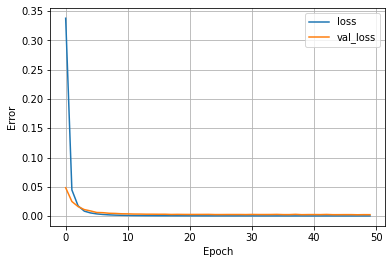

In [9]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylabel('Error')
plt.grid(True)

## Check the quality of the prediction

66/66 [==============================] - 1s 3ms/step


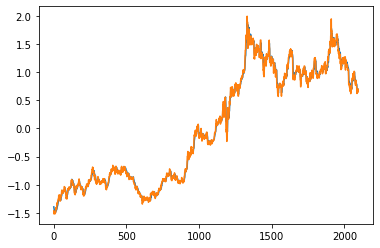

In [10]:
y_pred = (model.predict(testX))
plt.plot(y_pred)
plt.plot(testY)

## Profit with a simple trading strategy

2911.3040000000015


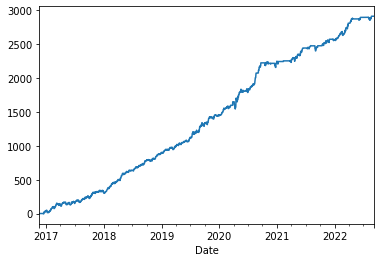

In [11]:
sz=train.shape[0]
profit=[0]
for i in range(LSTM_look_back-1):
    profit.append(0)
n=len(df.index)-LSTM_look_back
cond=0

Commence_Trade=1.00001
Hold=1

for i in range(sz, n):
    j=i-sz
    
    if y_pred[j]>=Commence_Trade*testX[j][0][0]:
        cond=1
    elif y_pred[j]<Hold*testX[j][0][0] and y_pred[j]>-Hold*testX[j][0][0]:
        cond=0
    elif y_pred[j]<=-Commence_Trade*testX[j][0][0]:
        cond=-1
    
    if cond==1:
        profit.append(profit[-1]+df2.iloc[i])
    elif cond==-1:
        profit.append(profit[-1]-df2.iloc[i])
    else:
        profit.append(profit[-1])    
        

dfr=test.copy()
dfr['Profit']=profit
dfr['Profit'].plot()
print(profit[-1])